<a href="https://colab.research.google.com/github/Zenith1618/LLM/blob/main/Spanish_to_English_Seq2Seq_Model_with_Dot_product_Attention_Mechanism.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing Libraries


In [1]:
!pip install fake_useragent

In [2]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import requests
import string
import re
import random
import os
import shutil
import zipfile
import pandas as pd
from fake_useragent import UserAgent    #library to mimic a user agent in the headers to make it appear more like a request from a web browser.


import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
device

device(type='cuda')

# Downloading and Loading the dataset

In [13]:
url = 'http://www.manythings.org/anki/spa-eng.zip'
filename = 'spa-eng.zip'
path = os.getcwd()
zipfilename = os.path.join(path, filename)

# Use a fake user agent to mimic a browser request
headers = {'User-Agent': UserAgent().random}

# Download the zip file
response = requests.get(url, stream=True, headers=headers)
if response.status_code == 200 and 'Content-Type' in response.headers and response.headers['Content-Type'] == 'application/zip':
    with open(zipfilename, 'wb') as out_file:
        shutil.copyfileobj(response.raw, out_file)

    # Extract the contents of the zip file
    with zipfile.ZipFile(zipfilename, 'r') as zip_ref:
        zip_ref.extractall(path)

    # Remove the downloaded zip file if needed
    # os.remove(zipfilename)
else:
    print("Failed to download the zip file. Check the URL or try again later.")


In [14]:
!ls

_about.txt  sample_data  spa-eng.zip  spa.txt


# Preparation for Data Processing

Unlike dozens of characters in a single language, the encoding vector is very large because there are so many words in the translation. Therefore, we will refine the data to use only thousands of words per language using the method.

Create a class to store downloaded data as word->index, index->words and replace rare words.

In [15]:
SOS_token = 0
EOS_token = 1

class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: 'SOS', 1: 'EOS'}
        self.n_words = 2

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

The file is all Unicode, which converts Unicode characters to ASCII for simplicity, makes all characters lowercase, and erases most punctuation.

In [16]:
# Convert Unicode strings to plain ASCII
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Remove lowercase letters, trimming, and non-character characters
def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

To read the data file we will split the file into lines, and then split lines into pairs. The files are all English → Other Language, so if we want to translate from Other Language → English I added the reverse flag to reverse the pairs

In [17]:
def readLangs(lang1, lang2, reverse=False):
    print("Reading lines...")

    # Read the file and separate it into lines
    lines = open('./%s.txt' % (lang2), encoding='utf-8').\
        read().strip().split('\n')

    # Separate all lines in pairs and normalize
    pairs = [[normalizeString(s) for s in l.split('\t')][:2] for l in lines]

    # Flip pairs, create Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

Since there are a lot of example sentences so we’ll trim the data set to only relatively short and simple sentences. Here the maximum length is 10 words (that includes ending punctuation) and we’re filtering to sentences that translate to the form “I am” or “He is” etc. (accounting for apostrophes replaced earlier).

The full process for preparing the data is:

*   Read text file and split into lines, split lines into pairs
*   Normalize text, filter by length and content
*   Make word lists from sentences in pairs

In [18]:
MAX_LENGTH = 10

eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s ",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)


def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and len(p[1].split(' ')) < MAX_LENGTH and p[1].startswith(eng_prefixes)

def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

In [19]:
def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs


input_lang, output_lang, pairs = prepareData('eng', 'spa', True)
print(random.choice(pairs))

Reading lines...
Read 141370 sentence pairs
Trimmed to 8614 sentence pairs
Counting words...
Counted words:
spa 4126
eng 2817
['eres muy inteligente .', 'you re very intelligent .']


# Modelling
## Encoder



The encoder of a seq2seq network is a RNN that outputs some value for every word from the input sentence. For every input word the encoder outputs a vector and a hidden state, and uses the hidden state for the next input word.

$\;\;\;\;\;\;\;\;$
<center><img src="https://pytorch.org/tutorials/_images/encoder-network.png"/ width="300" height="300" ></center>

$\;\;\;\;\;\;\;\;$

In [20]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

## The Decoder

The decoder is another RNN that takes the encoder output vector(s) and outputs a sequence of words to create the translation.

In the simplest seq2seq decoder we use only last output of the encoder. This last output is sometimes called the context vector as it encodes context from the entire sequence. This context vector is used as the initial hidden state of the decoder.

At every step of decoding, the decoder is given an input token and hidden state. The initial input token is the start-of-string <SOS> token, and the first hidden state is the context vector (the encoder’s last hidden state).

$\;\;\;\;\;\;\;\;$
<center><img src="https://pytorch.org/tutorials/_images/decoder-network.png"/ width="300" height="300" ></center>

$\;\;\;\;\;\;\;\;$

In [21]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        output = self.embedding(input).view(1, 1, -1)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

## Attention Decoder

Attention allows the decoder network to “focus” on a different part of the encoder’s outputs for every step of the decoder’s own outputs. First we calculate a set of attention weights. These will be multiplied by the encoder output vectors to create a weighted combination. The result (called attn_applied in the code) should contain information about that specific part of the input sequence, and thus help the decoder choose the right output words.

$\;\;\;\;\;\;\;\;$
<center><img src="https://i.imgur.com/1152PYf.png"/ width="300" height="300" ></center>

$\;\;\;\;\;\;\;\;$

Calculating the attention weights is done with another feed-forward layer attn, using the decoder’s input and hidden state as inputs. Because there are sentences of all sizes in the training data, to actually create and train this layer we have to choose a maximum sentence length (input length, for encoder outputs) that it can apply to. Sentences of the maximum length will use all the attention weights, while shorter sentences will only use the first few.

$\;\;\;\;\;\;\;\;$
<center><img src="https://pytorch.org/tutorials/_images/attention-decoder-network.png"/ width="300" height="300" ></center>

$\;\;\;\;\;\;\;\;$

In [22]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

# Trainig Data Preparation

To train, for each pair we will need an input tensor (indexes of the words in the input sentence) and target tensor (indexes of the words in the target sentence). While creating these vectors we will append the EOS token to both sequences.

In [23]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]


def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)


def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

# Train


To train we run the input sentence through the encoder, and keep track of every output and the latest hidden state. Then the decoder is given the <SOS> token as its first input, and the last hidden state of the encoder as its first hidden state.

“Teacher forcing” is the concept of using the real target outputs as each next input, instead of using the decoder’s guess as the next input. Using teacher forcing causes it to converge faster but when the trained network is exploited, it may exhibit instability.

You can observe outputs of teacher-forced networks that read with coherent grammar but wander far from the correct translation - intuitively it has learned to represent the output grammar and can “pick up” the meaning once the teacher tells it the first few words, but it has not properly learned how to create the sentence from the translation in the first place.

Because of the freedom PyTorch’s autograd gives us, we can randomly choose to use teacher forcing or not with a simple if statement. Turn teacher_forcing_ratio up to use more of it.

In [24]:
teacher_forcing_ratio = 0.5


def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

This is a helper function to print time elapsed and estimated time remaining given the current time and progress %.



In [25]:
import time
import math


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

The whole training process looks like this:

* Start a timer
* Initialize optimizers and criterion
* Create set of training pairs
* Start empty losses array for plotting

Then we call train many times and occasionally print the progress (% of examples, time so far, estimated time) and average loss.

In [26]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np


def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()

    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

In [27]:
%matplotlib inline
def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    training_pairs = [tensorsFromPair(random.choice(pairs))
                      for i in range(n_iters)]
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)

# Evaluate

Evaluation is mostly the same as training, but there are no targets so we simply feed the decoder’s predictions back to itself for each step. Every time it predicts a word we add it to the output string, and if it predicts the EOS token we stop there. We also store the decoder’s attention outputs for display later.

In [28]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions[:di + 1]

We can evaluate random sentences from the training set and print out the input, target, and output to make some subjective quality judgements

In [29]:
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, attentions = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

# Training and Evaluation

1m 37s (- 22m 43s) (5000 6%) 3.0608
3m 12s (- 20m 53s) (10000 13%) 2.3971
4m 46s (- 19m 5s) (15000 20%) 2.0977
6m 19s (- 17m 22s) (20000 26%) 1.8016
7m 50s (- 15m 41s) (25000 33%) 1.5633
9m 23s (- 14m 5s) (30000 40%) 1.4012
10m 58s (- 12m 32s) (35000 46%) 1.1940
12m 31s (- 10m 57s) (40000 53%) 1.1037
14m 6s (- 9m 24s) (45000 60%) 0.9586
15m 40s (- 7m 50s) (50000 66%) 0.8509
17m 14s (- 6m 16s) (55000 73%) 0.7837
18m 48s (- 4m 42s) (60000 80%) 0.7305
20m 22s (- 3m 8s) (65000 86%) 0.6729
21m 56s (- 1m 34s) (70000 93%) 0.5763
23m 32s (- 0m 0s) (75000 100%) 0.5396


<Figure size 640x480 with 0 Axes>

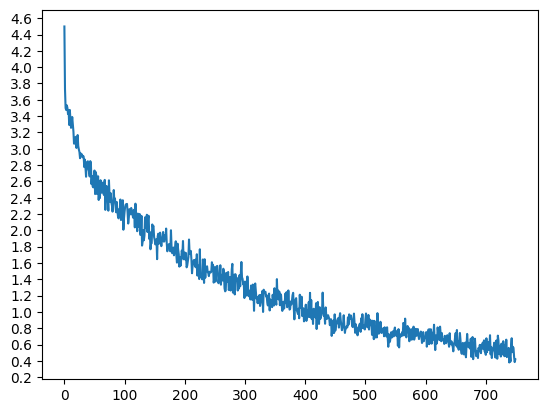

In [30]:
hidden_size = 256
encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
attn_decoder1 = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.1).to(device)

trainIters(encoder1, attn_decoder1, 75000, print_every=5000)

You can see that the leftmost loss decreases as the learning progresses. We also show fast learning time on a large number of 75,000 iteration

In [36]:
evaluateRandomly(encoder1, attn_decoder1)

>  tengo sueno !
= i m sleepy !
< i m sleepy ! <EOS>

> no estoy asegurada .
= i m uninsured .
< i m not ready . <EOS>

> eres bueno en frances no ?
= you re good at french aren t you ?
< you re good at french aren t you ? <EOS>

> eres un maleducado .
= you are rude .
< you re an . <EOS>

> los dos estamos bien .
= we re both fine .
< we re both fine . <EOS>

> no soy una persona violenta .
= i m not a violent person .
< i m not a bad person . <EOS>

> el es guapo e inteligente .
= he is handsome and clever .
< he is intelligent and good looking . <EOS>

> el la esta chantajeando .
= she is being blackmailed by him .
< she is this this . . <EOS>

> estamos decepcionados con los resultados .
= we re disappointed with the results .
< we re with the same boat . <EOS>

> nosotros compartimos el mismo destino .
= we re in the same boat .
< we re in the same boat . <EOS>



# Visualization

A useful property of the attention mechanism is its highly interpretable outputs. Because it is used to weight specific encoder outputs of the input sequence, we can imagine looking where the network is focused most at each time step

input = estoy muy agradecido por tu ayuda .
output = i am very grateful for your help . <EOS>


<ipython-input-41-04f69332eeb5>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + input_sentence.split(' ') + [''], rotation=90)
<ipython-input-41-04f69332eeb5>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + output_words)


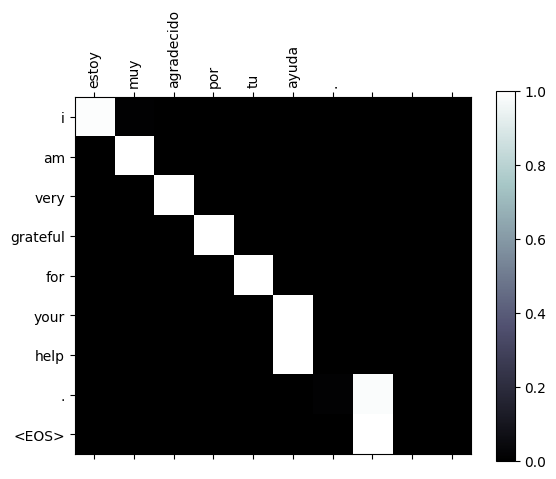

input = perdon pero mi padre no esta en casa .
output = i m sorry my father is out . <EOS>


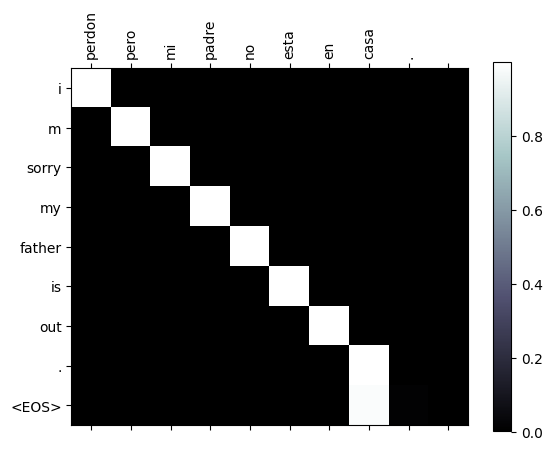

input = el no es nada honesto .
output = he is not honest at all . <EOS>


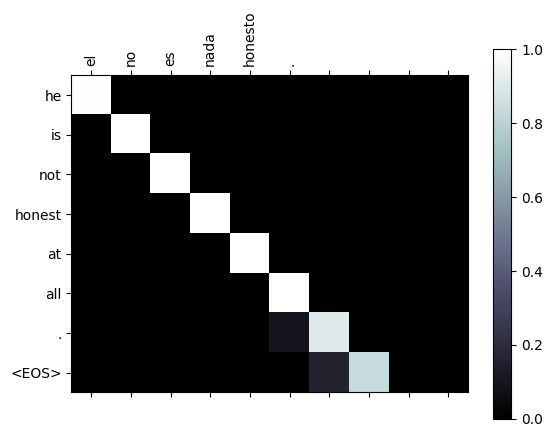

In [41]:
def showAttention(input_sentence, output_words, attentions):

    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)


    ax.set_xticklabels([''] + input_sentence.split(' ') + [''], rotation=90)
    ax.set_yticklabels([''] + output_words)


    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def evaluateAndShowAttention(input_sentence):
    output_words, attentions = evaluate(
        encoder1, attn_decoder1, input_sentence)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    showAttention(input_sentence, output_words, attentions)


evaluateAndShowAttention("estoy muy agradecido por tu ayuda .")
evaluateAndShowAttention("perdon pero mi padre no esta en casa .")
evaluateAndShowAttention("el no es nada honesto .")





# Conclusion

Attention Mechanism has been proposed in RNN to prevent deterioration in translation performance due to bottlenecks when sentence length is extended. Recently, self-attention concepts that parallelize them have emerged, and even models that use self-attention to perform better without RNN (Transformer, BERT, etc.) have been pouring out. In order to understand and learn the underlying skills of the latest models, I think it is essential to study Attention Mechanism well.